<!-- # Modeling
This modeling script shows all the steps taken to model the data -->

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from src.static import DATA_DIR
from sklearn.preprocessing import FunctionTransformer
import numpy as np
%matplotlib inline

In [2]:
# Load Data
df = pd.read_csv(f'{DATA_DIR}/preprocessed_data.csv')
df.drop('num_bedrooms_0-1', axis=1, inplace=True)

<!-- ## Train Test Split
The next step will split our data into training, validation, and testing sets. To mimic real world contidions our model will train on the earlier years of the data and use the newer years as validation and testing sets.  -->

In [3]:
df.year.value_counts().sort_index().cumsum()

year
2019     7284
2020    15295
2021    22764
2022    29742
2023    34268
Name: count, dtype: int64

In [4]:
print(f'Training records from 2021 and before make up {round((22764 * 100) / df.shape[0], 2)}% of the data.')

Training records from 2021 and before make up 66.43% of the data.


In [5]:
print(f'Validation & Testing records from 2022 make up {round(((df.shape[0] - 22764)* 100) / df.shape[0], 2)}% of the data.')

Validation & Testing records from 2022 make up 33.57% of the data.


<!-- Our target variable is the `num_affordable_units` column. This information is derived from the `affordability_levels` columns, so in order to prevent data leaks these columns cannot be provided to the model. They will be removed here. -->

In [6]:
df = df[[x for x in df.columns if not x.startswith('affordability')]].set_index('record_number')

<!-- The next step is to split off the training variables and prepare the validation and test sets. -->

In [7]:
X_train, X, y_train, y = (df[df.year <= 2021].drop(['num_affordable_units'], axis=1),
               df[df.year > 2021].drop(['num_affordable_units'], axis=1),
               df[df.year <= 2021].num_affordable_units,
               df[df.year > 2021].num_affordable_units)

<!-- We will scale the X variables by standard deviation using Sklearn's standard scaler. Consistent varaible sizing improves performance on most models. -->

In [ ]:
# instantiate scaler obj
scaler = StandardScaler()

# fit only to training data
scaler.fit(X_train)

# transform X sets
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)

<!-- Now that everything has been scaled we will continue to split out the testing and validation sets. We will use Sklearn's train_test_split, and we will split the non-training data from 2022 and 2023 into a 50% 50% split, stratified by year. The stratification on the year variable will assue that the distribution of records from one year to the next will stay consistent between the two otherwise randomly selected datasets. -->

In [10]:
# train test split
X_val_scaled, X_test_scaled, y_val, y_test = train_test_split(
    X_scaled, y, test_size = 0.5, stratify=X['year'], random_state=42
    )

<!-- # Linear Regression
Now we will attempt a simple linear regression analysis using our training and validation sets to see what our baseline performance will be. More complex models will be attempted afterwards -->

In [11]:
# instantiate LinearRegression object
model = LinearRegression()

# fit training data
model.fit(X_train_scaled, y_train)

# make predictions
y_pred = model.predict(X_val_scaled)

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 947.3499825733098
R-squared Score: 0.3767936312853548


In [12]:
# observe model coefficients
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'year': -2679.2166637511887,
 'census_tract_2020': -9.994613183758863,
 'tract_income_ratio': -18.59392627639774,
 'num_units': 25.550928488487457,
 'num_bedrooms_>=2': 0.6780109424118579,
 'enterprise_flag_freddie': -41.17436477276599,
 'date_of_mortgage_note_same year as acquired': -8.388350878404593,
 'purpose_of_loan_new build': -10.149216826899808,
 'purpose_of_loan_purchase': -42.42710230588063,
 'purpose_of_loan_refinance': -41.86327347497929,
 'type_of_seller_SAIF or BIF': 0.5559078411034588,
 'type_of_seller_mortgage_company': -3.12293875304152,
 'federal_guarantee_no': 1.0562481347977126,
 'federal_guarantee_yes': -29.32146986543229,
 'tot_num_units_25-50': 2.6474087633560393,
 'tot_num_units_5-24': 17.8770062975573,
 'tot_num_units_51-99': 0.8579843626129723,
 'tot_num_units_> 149': -5.000517053110936,
 'after_covid_ind': 2.894728998928624}

<!-- The massive coefficients on the naive linear regression indicate that there is multicolinearity throwing off our coefficient sizing. We can will use regularization and feature selection techinques to mitigate these issues -->

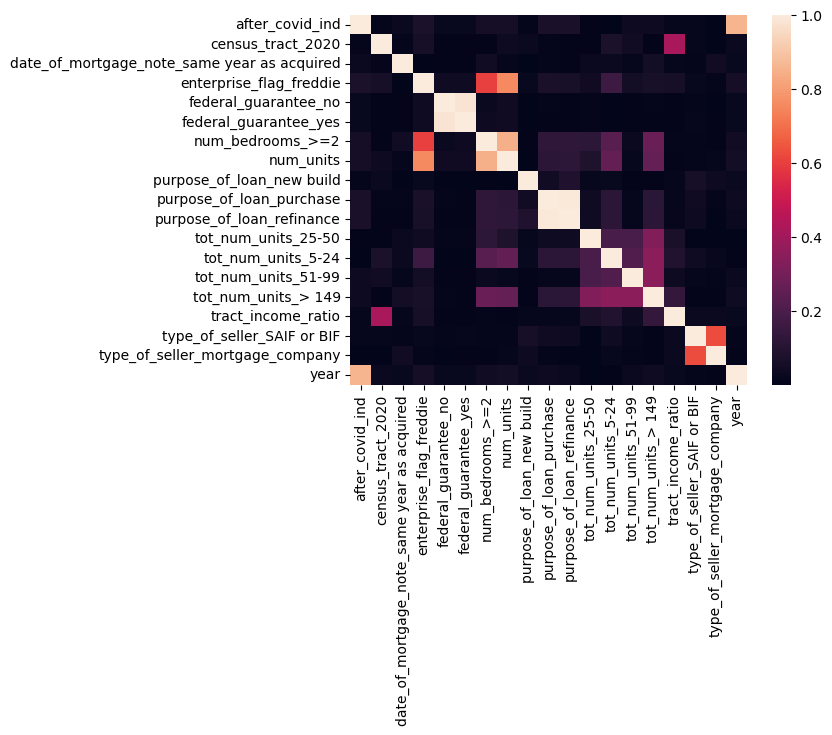

In [13]:
# plot correlation heatmap
sns.heatmap(X_train_scaled[sorted(X_train_scaled.columns)].corr().apply(abs));

In [14]:
# Set up RFE
rfe = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]
cols

array(['year', 'census_tract_2020', 'tract_income_ratio', 'num_units',
       'enterprise_flag_freddie', 'purpose_of_loan_new build',
       'purpose_of_loan_purchase', 'purpose_of_loan_refinance',
       'federal_guarantee_yes', 'tot_num_units_5-24'], dtype=object)

<!-- ### Re-test with reduced feature set -->

In [15]:
# instantiate LinearRegression object
model = LinearRegression()

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 936.9028937220496
R-squared Score: 0.38366616247910423


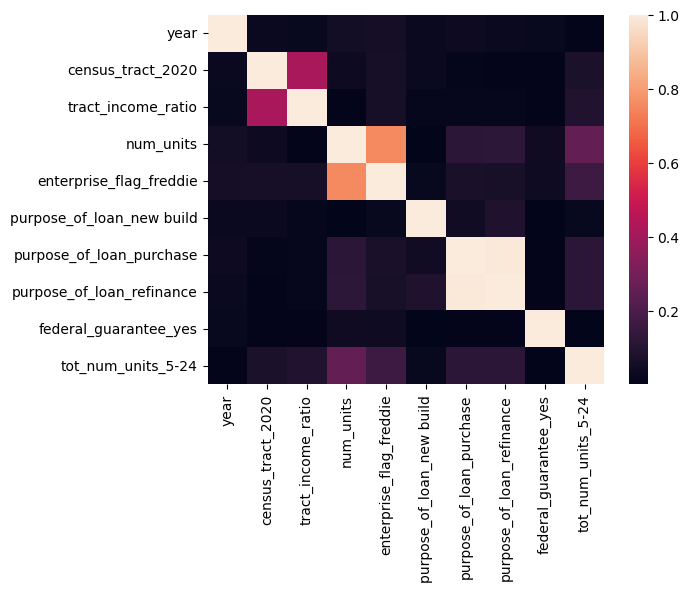

In [16]:
# plot correlation heatmap
sns.heatmap(X_train_scaled[cols].corr().apply(abs));

<!-- Using RFE has removed 21 extrenous features at little to no cost of performance on validation. RFE will be a useful component of model selection moving forward -->

<!-- # Lasso Regression
Lasso regression uses L1 regularization which penalizes coeficients on variables to reduce variance and increase bias. Lasso regularization also has the added beneifit of potentially reducing features down event further since the shrinking factor on variable coefficients can go all the way to zero. The regularization parameter alpha can be set to a number that increases or reduces the strength of the regularization. We can iteratively test multiple values for this using a grid search which will fit and test models at different values for alpha -->

In [17]:
# define search parameters
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# perform search for best value
grid_search = GridSearchCV(estimator=Lasso(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

In [18]:
# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 924.1965427693641
R-squared Score: 0.3920249306033483


<!-- Lasso regression seems to perform marginally better than the unregularized model by reducing the mean squared error slightly.  -->

In [19]:
model

Lasso(alpha=0.1)

<!-- An alpha value of 0.1 is selected for the regularization parameter. The following coefficients are used: -->

In [20]:
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'census_tract_2020': -5.59080659918879,
 'tract_income_ratio': -16.23616447340998,
 'num_units': 23.807277141639904,
 'num_bedrooms_>=2': 0.6915536070669616,
 'enterprise_flag_freddie': -35.02395559129455,
 'date_of_mortgage_note_same year as acquired': -6.229157339822782,
 'purpose_of_loan_purchase': -0.30130931032425307,
 'type_of_seller_mortgage_company': -1.9209587680005527,
 'tot_num_units_5-24': 12.327035064002912,
 'tot_num_units_> 149': -4.7453727763741265}

<!-- # Ridge Regression
Ridge regressionuses L2 regularization which also penalizes the coefficients but does not remove features entirely. It is performed via a different mathematical calculation, lets assess it's performance. -->

In [21]:
# define search parameters
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

# perform search for best value
grid_search = GridSearchCV(estimator=Ridge(), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# Set up RFE
rfe = RFE(estimator=best_model, n_features_to_select=10)
rfe = rfe.fit(X_train_scaled, y_train)

# Show selected features
cols = rfe.feature_names_in_[rfe.support_]

# instantiate LinearRegression object
model = best_model

# fit training data
model.fit(X_train_scaled[cols], y_train)

# make predictions
y_pred = model.predict(X_val_scaled[cols])

# gather performance metrics
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

# print report
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 933.2400478970968
R-squared Score: 0.386075735380061


<!-- Ridge regression performs marginally worse than Lasso regression. Let's examine the the coefficients -->

In [22]:
{k:v for k,v in zip(model.feature_names_in_, model.coef_)}

{'census_tract_2020': -10.547781812639581,
 'tract_income_ratio': -19.4919168874404,
 'num_units': 24.83657756475187,
 'enterprise_flag_freddie': -37.05126249916701,
 'purpose_of_loan_new build': 14.567862860469232,
 'purpose_of_loan_purchase': -14.743069954213546,
 'purpose_of_loan_refinance': -13.74186607740222,
 'federal_guarantee_no': 11.791807441396715,
 'federal_guarantee_yes': -12.815688582752928,
 'tot_num_units_5-24': 16.800947613233262}

<!-- This model swaps out some features but ultimately achieves marginally worse results

# Elastic Net
Elastic net combines the strengths of both Lasso and Ridge regression by mixing the two regularization parameters together.  -->

In [23]:
# # define search parameters
# param_grid = {
#     'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
#     'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1]
# }

# # perform search for best value
# grid_search = GridSearchCV(estimator=ElasticNet(random_state=42, max_iter=int(1e4)),
#                            param_grid=param_grid, cv=5, scoring='r2');
# grid_search.fit(X_train_scaled, y_train)
# best_model = grid_search.best_estimator_

# # Set up RFE
# rfe = RFE(estimator=best_model, n_features_to_select=10)
# rfe = rfe.fit(X_train_scaled, y_train)

# # Show selected features
# cols = rfe.feature_names_in_[rfe.support_]

# # instantiate LinearRegression object
# model = best_model

# # fit training data
# model.fit(X_train_scaled[cols], y_train)

# # make predictions
# y_pred = model.predict(X_val_scaled[cols])

# # gather performance metrics
# mse = mean_squared_error(y_val, y_pred)
# r2 = r2_score(y_val, y_pred)

# # print report
# print(f"Mean Squared Error: {mse}")
# print(f"R-squared Score: {r2}")

In [24]:
model

Ridge(alpha=10.0)

<!-- The elastic net model converged an l1_ratio which is equal to 100% Lasso, indicating that mixing Ridge and Lasso together did not improve the model performance and Lasso edges out Ridge on this data. -->

<!-- # XGBoost Regression
This model is a random forest regression that implements xgb gradient boosting. Gradient boosting is a powerful method to improve the performance of random forest ensemble using methods rooted in calculus. -->